In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import warnings
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import nltk

nltk.download('stopwords', quiet=True)
warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

In [2]:
# Load the datasets
train_df = pd.read_excel("../Datasets/Train.xlsx")
test_df  = pd.read_excel("../Datasets/Test.xlsx")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
print(train_df["Expected Operation by Developer"].value_counts())

Train shape: (931, 2)
Test  shape: (234, 2)
Expected Operation by Developer
insert     322
delete     309
replace    300
Name: count, dtype: int64


In [3]:
# Train-validation split
X = train_df["Review Comment"]
y = train_df["Expected Operation by Developer"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.10, random_state=SEED, stratify=y
)

print("Train size:", len(X_train), "   Val size:", len(X_val))

Train size: 837    Val size: 94


In [5]:
base_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),          # 1-2-grams
        min_df=2
    )),
    ("clf", LinearSVC(
        C=1.0,                       # will be tuned below
        loss="hinge",                # classic SVM hinge loss
        random_state=SEED
    ))
])

In [6]:
param_grid = {
    "tfidf__ngram_range": [(1,1), (1,2)],
    "tfidf__min_df": [1, 2, 3],
    "clf__C": [0.1, 0.5, 1, 2, 5, 10]
}

search = GridSearchCV(
    base_pipeline,
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="accuracy",
    verbose=1
)
search.fit(X_train, y_train)

print("Best CV-accuracy:", search.best_score_)
print("Best params:", search.best_params_)
best_pipeline = search.best_estimator_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/sit

Best CV-accuracy: 0.5627958368976334
Best params: {'clf__C': 10, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}


/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/salman/anaconda3/envs/GPU/lib/python3.10/sit

In [7]:
final_model = best_pipeline if 'best_pipeline' in globals() else base_pipeline
final_model.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),
                ('clf', LinearSVC(C=10, loss='hinge', random_state=42))])

Test accuracy: 0.6197

Classification report:
               precision    recall  f1-score   support

      delete       0.60      0.63      0.62        78
      insert       0.60      0.60      0.60        81
     replace       0.66      0.63      0.64        75

    accuracy                           0.62       234
   macro avg       0.62      0.62      0.62       234
weighted avg       0.62      0.62      0.62       234



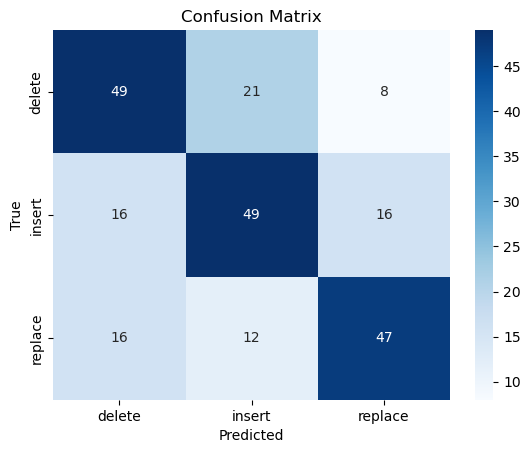

In [8]:
X_test  = test_df["Review Comment"]
y_test  = test_df["Expected Operation by Developer"]

y_pred  = final_model.predict(X_test)
acc     = accuracy_score(y_test, y_pred)

print(f"Test accuracy: {acc:.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

# Confusion matrix heat-map
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y),
            yticklabels=np.unique(y))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.show()


In [9]:
def show_top_weights(model, vectorizer, n=15):
    clf     = model.named_steps["clf"]
    tfidf   = model.named_steps["tfidf"]
    classes = clf.classes_

    feature_names = np.array(tfidf.get_feature_names_out())
    for i, c in enumerate(classes):
        top = np.argsort(clf.coef_[i])[-n:]
        print(f"\nClass '{c}' top terms:")
        print(", ".join(feature_names[top]))

show_top_weights(final_model, final_model.named_steps["tfidf"])



Class 'delete' top terms:
space shouldn, prohibited, space tab, tab line, removed, line functions, line statements, need, space alignment, don add, needed, extra, use space, space parens, remove

Class 'insert' top terms:
indention, use, pci devices, prefer using, align, unsigned int, maybe pointer, new line, start, use tabs, tab needed, just line, break line, uintptr_t file, add

Class 'replace' top terms:
lpc_gen1_dec, shouldn, capitalize, units, line curly, indent line, sizeof uint32_t, previous, coreboot, struct, started lower, started, zero default, coreboot lower, instead
